In [1]:
import pandas as pd
import pickle
import random
from rdkit import Chem
import itertools
import torch
import numpy as np
from enhancement_utility import generate_smiles, smiles_to_fingerprint

seed = 12

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
df = pd.read_csv('Doyle_cleaned.csv', index_col=False)
print(df.head(), len(df))
pickle_path = 'Doyle.pkl'

with open(pickle_path, 'rb') as file:
        model = pickle.load(file)

proxy_model = model.predict
THRESHOLD = 0.05

                                              Ligand         Additive  \
0  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P([C@]...      Cc1onc(c1)C   
1  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P([C@]...   COC(=O)c1ccno1   
2  CC(c1cc(cc(c1c1ccccc1P(C1CCCCC1)C1CCCCC1)C(C)C...   COC(=O)c1ccno1   
3  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  CCOC(=O)c1conc1   
4  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P([C@]...      Cc1onc(c1)C   

                                        Base           Aryl halide     Yield  
0  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C            Clc1ccccn1  0.704105  
1  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C            Brc1ccccn1  0.110645  
2  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C         CCc1ccc(cc1)I  0.102235  
3                           CN1CCCN2C1=NCCC2  FC(c1ccc(cc1)Cl)(F)F  0.200834  
4                           CN1CCCN2C1=NCCC2        COc1ccc(cc1)Cl  0.004927   3955


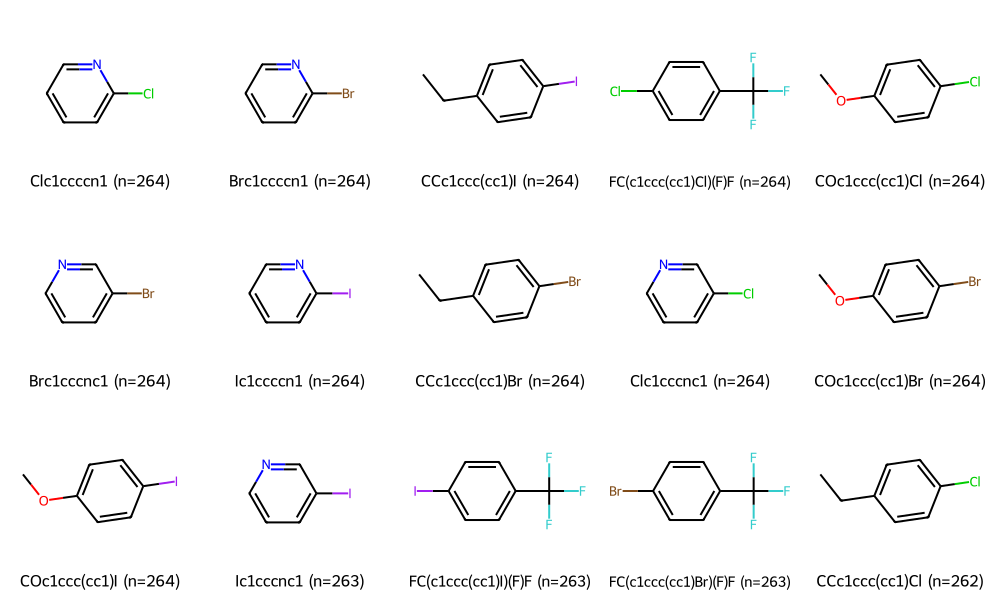

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Calculate the frequency of each unique SMILES
frequency = df['Aryl halide'].value_counts()

# Create a DataFrame with unique nucleophiles and their counts
unique_nucleophiles = pd.DataFrame({
    'Aryl halide': frequency.index,
    'Count': frequency.values
})

# Convert each unique SMILES to an RDKit Molecule object
unique_nucleophiles['Molecule'] = unique_nucleophiles['Aryl halide'].apply(Chem.MolFromSmiles)

# Prepare the list of molecules and the legends (SMILES + count)
mols = unique_nucleophiles['Molecule'].tolist()
legends = [f"{smi} (n={count})" for smi, count in zip(unique_nucleophiles['Aryl halide'], unique_nucleophiles['Count'])]

# Draw the molecules in a grid with the frequency in the legend
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=legends)

# Display the image within the Jupyter notebook
display(img)


In [4]:
halides = df['Aryl halide'].to_list()
random.shuffle(halides)
ligands = list(set(df['Ligand'].to_list()))
additives = list(set(df['Additive'].to_list()))
bases = list(set(df['Base'].to_list()))

halides_enhanced = []

In [5]:
for halide in halides:
    halides_enhanced.extend(generate_smiles(halide))

In [6]:
chlorine_pattern = Chem.MolFromSmarts('[c]Cl')
bromine_pattern = Chem.MolFromSmarts('[c]Br')
iodine_pattern = Chem.MolFromSmarts('[c]I')
halides_filtered = []
for smi in halides_enhanced:
    mol = Chem.MolFromSmiles(smi)
    if mol.HasSubstructMatch(chlorine_pattern) or mol.HasSubstructMatch(bromine_pattern) or mol.HasSubstructMatch(iodine_pattern):
        halides_filtered.append(smi)

halides_filtered = list(set(halides_filtered))
print(len(halides_filtered))

205


In [7]:
combinations = list(itertools.product(ligands, additives, bases, halides_filtered))
print(len(combinations), len(halides_filtered))
df_enhanced = pd.DataFrame(combinations, columns=['Ligand', 'Additive', 'Base', 'Aryl halide'])
print(df_enhanced.head(), len(df_enhanced))

54120 205
                                              Ligand  Additive  \
0  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
1  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
2  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
3  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
4  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   

                                        Base          Aryl halide  
0  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C    FC(F)c1ccc(Cl)cc1  
1  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C     [C+]Oc1ccc(I)cc1  
2  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C  C=[C+]Cc1ccc(Cl)cc1  
3  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C    [S-]CCc1ccc(I)cc1  
4  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C   [S+]CCc1ccc(Cl)cc1   54120


In [8]:
fingerprints = []
for index, row in df_enhanced.iterrows():
    ligand_fp = smiles_to_fingerprint(row['Ligand'])
    additive_fp = smiles_to_fingerprint(row['Additive'])
    base_fp = smiles_to_fingerprint(row['Base'])
    halide_fp = smiles_to_fingerprint(row['Aryl halide'])

    concatenated_fp = torch.cat((ligand_fp, additive_fp, base_fp, halide_fp))
    fingerprints.append(concatenated_fp)

X = torch.stack(fingerprints)
print(X.shape)

y = proxy_model(X)
print(y.shape)

df_enhanced['Yield'] = y

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['Ligand'].unique()), len(df_enhanced['Additive'].unique()), len(df_enhanced['Base'].unique()), len(df_enhanced['Aryl halide'].unique()))

torch.Size([54120, 4096])
(54120,)
                                              Ligand  Additive  \
0  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
1  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
2  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
3  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
4  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   

                                        Base          Aryl halide     Yield  
0  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C    FC(F)c1ccc(Cl)cc1  0.021132  
1  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C     [C+]Oc1ccc(I)cc1  0.530253  
2  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C  C=[C+]Cc1ccc(Cl)cc1  0.021489  
3  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C    [S-]CCc1ccc(I)cc1  0.670088  
4  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C   [S+]CCc1ccc(Cl)cc1  0.021822   54120
4 22 3 205


In [9]:
mean_yield = df_enhanced.groupby('Aryl halide')['Yield'].mean()

halides_below_threshold = mean_yield[mean_yield < THRESHOLD].index
print(len(halides_below_threshold))

df_enhanced = df_enhanced[df_enhanced['Aryl halide'].isin(halides_below_threshold)]

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['Ligand'].unique()), len(df_enhanced['Additive'].unique()), len(df_enhanced['Base'].unique()), len(df_enhanced['Aryl halide'].unique()))

15
                                               Ligand  Additive  \
26  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
36  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
37  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
41  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   
80  COc1ccc(c(c1c1c(cc(cc1C(C)C)C(C)C)C(C)C)P(C(C)...  Cc1ccon1   

                                         Base         Aryl halide     Yield  
26  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C   COc1[c-]cc(Cl)cc1  0.011408  
36  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C      COc1ccc(Cl)cc1  0.000522  
37  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C  CC[C+]c1ccc(Cl)cc1  0.035404  
41  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C   CCc1[c-]cc(Cl)cc1  0.045242  
80  CCN=P(N(C)C)(N(C)C)N=P(N(C)C)(N(C)C)N(C)C      CCc1ccc(Cl)cc1  0.062430   3960
4 22 3 15


In [10]:
final_df = pd.concat([df, df_enhanced], ignore_index=True)

print(len(final_df), len(final_df['Aryl halide'].unique()), len(final_df['Ligand'].unique()), len(final_df['Additive'].unique()), len(final_df['Base'].unique()))

final_df.to_csv('Doyle_enhanced.csv', index=False)

7915 30 4 22 3
